<a href="https://colab.research.google.com/github/zakariaelaoufi/Arcface-Pytorch/blob/main/arcface_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install opendatasets --quiet

!pip install opendatasets --quiet

import opendatasets as od
import os

od.download('https://www.kaggle.com/datasets/hearfool/vggface2')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sdff
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/hearfool/vggface2


100%|██████████| 2.32G/2.32G [00:16<00:00, 149MB/s]


In [ ]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
path_data = '/content/vggface2'

In [ ]:
def generate_vggface_df(dir):
  image_path = []
  image_label = []
  for folder in os.listdir(dir):
      for label in os.listdir(dir + "/" + folder):
          for image in os.listdir(dir + "/" + folder + "/" + label):
              curr_path = dir + "/" + folder + "/" + label + "/" + image
              image_path.append(curr_path)
              image_label.append(label)

  return pd.DataFrame(zip(image_path, image_label), columns = ['image_path', 'label'])

In [ ]:
train_df = generate_vggface_df(path_data)
# val_df = generate_vggface_df(path_val)

In [ ]:
len(train_df)

197693

In [ ]:
class_idx = {}
for i, label in enumerate(sorted(train_df['label'].unique())):
    class_idx[label] = i

In [ ]:
train_df['label_'] = train_df['label'].map(class_idx)

In [ ]:
train_df.to_csv("vggfave_train.csv")
# val_df.to_csv("vggfave_val.csv")

In [ ]:
train_df.sample(5)

,image_path,label,label_
50649,/content/vggface2/train/n000133/0113_01.jpg,n000133,132
96281,/content/vggface2/train/n000472/0358_01.jpg,n000472,467
43154,/content/vggface2/train/n000457/0022_01.jpg,n000457,452
70636,/content/vggface2/train/n000243/0121_02.jpg,n000243,239
70450,/content/vggface2/train/n000243/0162_01.jpg,n000243,239


In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_df, test_size=0.12, stratify=train_df['label_'], random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.4, stratify=val_df['label_'], random_state=42)

In [ ]:
val_df.sample(5)

,image_path,label,label_
94486,/content/vggface2/train/n000411/0101_01.jpg,n000411,406
9122,/content/vggface2/train/n000469/0152_01.jpg,n000469,464
59971,/content/vggface2/train/n000006/0088_02.jpg,n000006,5
16037,/content/vggface2/train/n000234/0178_01.jpg,n000234,230
135293,/content/vggface2/train/n000296/0172_02.jpg,n000296,292


In [ ]:
test_df.sample(5)

,image_path,label,label_
106509,/content/vggface2/train/n000233/0196_02.jpg,n000233,229
60037,/content/vggface2/train/n000006/0297_02.jpg,n000006,5
89808,/content/vggface2/train/n000134/0384_01.jpg,n000134,133
71409,/content/vggface2/train/n000186/0456_01.jpg,n000186,183
176747,/content/vggface2/val/n000480/0483_02.jpg,n000480,475


In [ ]:
len(train_df), len(val_df), len(test_df)

(173969, 14234, 9490)

<Axes: ylabel='Frequency'>

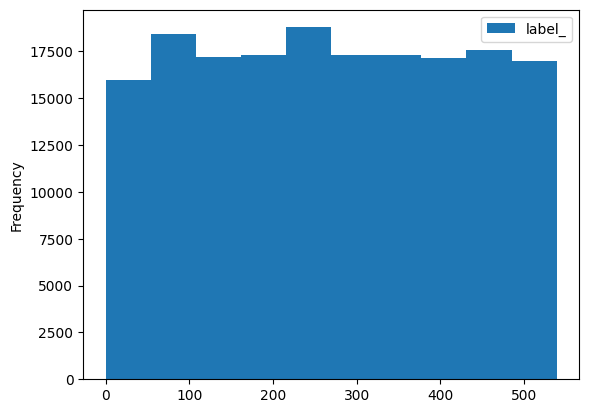

In [ ]:
train_df.plot(kind='hist')

In [ ]:
path_sample = val_df.sample(1).iloc[0]
print(path_sample)

image_path    /content/vggface2/train/n000081/0175_01.jpg
label                                             n000081
label_                                                 80
Name: 45151, dtype: object


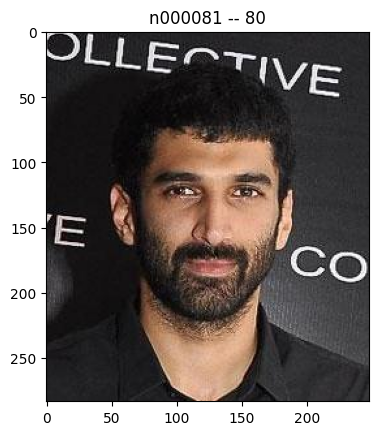

In [ ]:
image = cv2.imread(path_sample['image_path'])
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.title(f"{path_sample['label']} -- {path_sample['label_']}")
plt.imshow(image_rgb)
plt.show()

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from torchvision.transforms import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
import datetime as dt
from sklearn.metrics import accuracy_score
import kagglehub

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def resize_image(image, dsize=(224, 224)):
    resized_image = cv2.resize(image, dsize=dsize, interpolation=cv2.INTER_LANCZOS4)
    return resized_image

In [ ]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

transform_augmented = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [ ]:
class customDatasets(Dataset):
  def __init__(self, dataframe, transform=None):
     super().__init__()
     self.dataframe = dataframe
     self.transform = transform

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):
    image_path = self.dataframe.iloc[index, 0]
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError(f"Image not found or unreadable at path: {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image_resized = resize_image(image)

    label = torch.tensor(int(self.dataframe.iloc[index, 2]), dtype=torch.long)

    if self.transform:
        image_resized = self.transform(image_resized)

    return image_resized, label


In [ ]:
original_train_dataset = customDatasets(train_df, transform=transformer)
test_dataset = customDatasets(test_df, transform=transformer)
val_dataset = customDatasets(val_df, transform=transformer)
augmented_train_dataset = customDatasets(train_df.sample(frac=0.75), transform=transform_augmented)

In [ ]:
train_dataset = torch.utils.data.ConcatDataset([original_train_dataset, augmented_train_dataset])

In [ ]:
BATCH_SIZE = 128

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

(224, 224, 3)


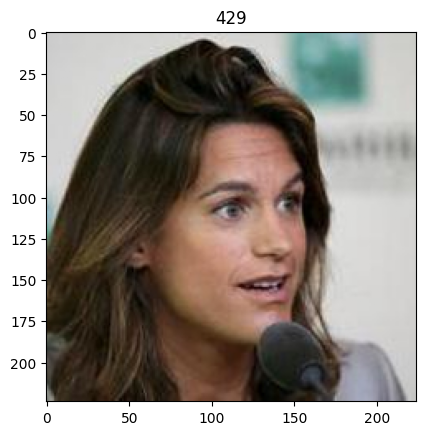

In [ ]:
images, labels = next(iter(train_dataloader))
images = images.cpu().numpy()
labels = labels.cpu().numpy()

for i in range(len(images)):
    image = images[i].transpose(1, 2, 0)  # Convert (C, H, W) → (H, W, C)

    print(image.shape)
    plt.imshow(image, cmap='gray')
    plt.title(labels[i])
    plt.show()
    break

In [ ]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, padding=padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.pointwise(self.depthwise(x))))

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = DepthwiseSeparableConv(channels, channels)
        self.conv2 = DepthwiseSeparableConv(channels, channels)

    def forward(self, x):
        return x + self.conv2(self.conv1(x))

class EfficientFRBackbone(nn.Module):
    def __init__(self, embedding_dim=512):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),  # Downsample
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.stage1 = nn.Sequential(
            DepthwiseSeparableConv(32, 64),
            ResidualBlock(64),
            nn.MaxPool2d(2)
        )

        self.stage2 = nn.Sequential(
            DepthwiseSeparableConv(64, 128),
            ResidualBlock(128),
            nn.MaxPool2d(2)
        )

        self.stage3 = nn.Sequential(
            DepthwiseSeparableConv(128, 256),
            ResidualBlock(256),
            nn.MaxPool2d(2)
        )

        self.stage4 = nn.Sequential(
            DepthwiseSeparableConv(256, 512),
            ResidualBlock(512),
            nn.AdaptiveAvgPool2d((1, 1))  # Global pooling
        )

        self.embedding = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, embedding_dim),
            nn.BatchNorm1d(embedding_dim)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.embedding(x)
        return x

In [ ]:
class ArcFace(nn.Module):
    def __init__(self, in_features, num_classes, s=30.0, m=0.5):
        super().__init__()
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.randn(num_classes, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, embeddings, labels):
        embeddings = F.normalize(embeddings)
        W = F.normalize(self.weight)

        # Cosine similarity
        cos_theta = torch.matmul(embeddings, W.t()).clamp(-1, 1)

        # Apply angular margin
        theta = torch.acos(cos_theta)
        cos_theta_m = torch.cos(theta + self.m)

        # One-hot encoding
        one_hot = F.one_hot(labels, num_classes=num_classes).float()

        # Apply margin to correct class
        logits = self.s * (one_hot * cos_theta_m + (1 - one_hot) * cos_theta)
        return logits

In [ ]:
class FaceNet(nn.Module):
    def __init__(self, num_classes, embedding_dim=512):
        super().__init__()
        self.backbone = EfficientFRBackbone(embedding_dim)
        self.arcface = ArcFace(embedding_dim, num_classes)

    def forward(self, x, labels=None):
        embeddings = self.backbone(x)
        if labels is not None:
            return self.arcface(embeddings, labels)
        return embeddings

In [ ]:
num_classes = len(train_df['label'].unique())
num_class2 = len(val_df['label'].unique())
num_class3 = len(test_df['label'].unique())
print(num_classes, num_class2, num_class3)

540 540 540


In [ ]:
train_files = set(train_df['image_path'])
val_files = set(val_df['image_path'])
print(f"Overlapping files: {len(train_files & val_files)}")

Overlapping files: 0


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = FaceNet(num_classes=num_classes, embedding_dim=512).to(device)
# print(f"Model initialized on {device}")

In [ ]:
model = FaceNet(num_classes=num_classes, embedding_dim=512).to(device)
print(f"Model initialized on {device}")

Model initialized on cuda


In [ ]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
            Conv2d-5         [-1, 64, 112, 112]           2,048
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
DepthwiseSeparableConv-8         [-1, 64, 112, 112]               0
            Conv2d-9         [-1, 64, 112, 112]             576
           Conv2d-10         [-1, 64, 112, 112]           4,096
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
DepthwiseSeparableConv-13         [-1, 64, 112, 112]               0
           Conv2d-14         [

In [ ]:
EPOCHS = 4
learning_rate = 1e-3
criterion = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
history = {
    'train_loss': [], 'dev_loss': [],
    'train_acc': [], 'dev_acc': [],
    'lr': []
}

In [ ]:
resume = True

In [ ]:
checkpoint = torch.load('/content/arcface_model_artifact_62', map_location=device)
if resume:
    if checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        history = checkpoint['history']
        start_epoch = checkpoint['epoch']
        print(f"Loaded checkpoint from epoch {start_epoch}")
    else:
        print("No checkpoint found. Starting from scratch.")

Loaded checkpoint from epoch 62


In [ ]:
torch.save(model.state_dict(), f'arcface_model.pth')

In [ ]:
/0

In [ ]:
start_time = dt.datetime.now()

for epoch in range(EPOCHS):
    # === Training phase ===
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    train_loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1} [Train]")
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = torch.argmax(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

        train_loop.set_postfix(loss=loss.item())

    # === Validation phase ===
    model.eval()
    epoch_dev_loss = 0
    dev_correct = 0
    dev_total = 0

    with torch.no_grad():
        dev_loop = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]")
        for images, labels in dev_loop:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images, labels)
            loss = criterion(outputs, labels)
            epoch_dev_loss += loss.item()

            preds = torch.argmax(outputs, 1)
            dev_correct += (preds == labels).sum().item()
            dev_total += labels.size(0)

            dev_loop.set_postfix(val_loss=loss.item())

    # === Calculate metrics ===
    train_loss = epoch_train_loss / len(train_dataloader)
    dev_loss = epoch_dev_loss / len(val_dataloader)
    train_acc = train_correct / train_total
    dev_acc = dev_correct / dev_total
    current_lr = optimizer.param_groups[0]['lr']

    # === Update history ===
    history['train_loss'].append(train_loss)
    history['dev_loss'].append(dev_loss)
    history['train_acc'].append(train_acc)
    history['dev_acc'].append(dev_acc)
    history['lr'].append(current_lr)

    # Update scheduler
    scheduler.step(dev_acc)

    # === Print epoch summary ===
    print(f"\nEpoch {epoch+1}/{EPOCHS} Summary:")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {dev_loss:.4f} | Acc: {dev_acc:.4f}")
    print(f"Current Learning Rate: {current_lr:.6f}")
    print("-" * 60)

    # === Save checkpoint every 10 epochs ===
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history
        }, f'arcface_model_artifact_{epoch}')

# Training completion
end_time = dt.datetime.now()
print(f"Training completed in: {end_time - start_time}")
torch.save(model.state_dict(), f'arcface_model.pth')

In [ ]:
torch.save({
            'epoch': epoch + 1 + 58,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history
        }, f'arcface_model_artifact_{EPOCHS + 58}')

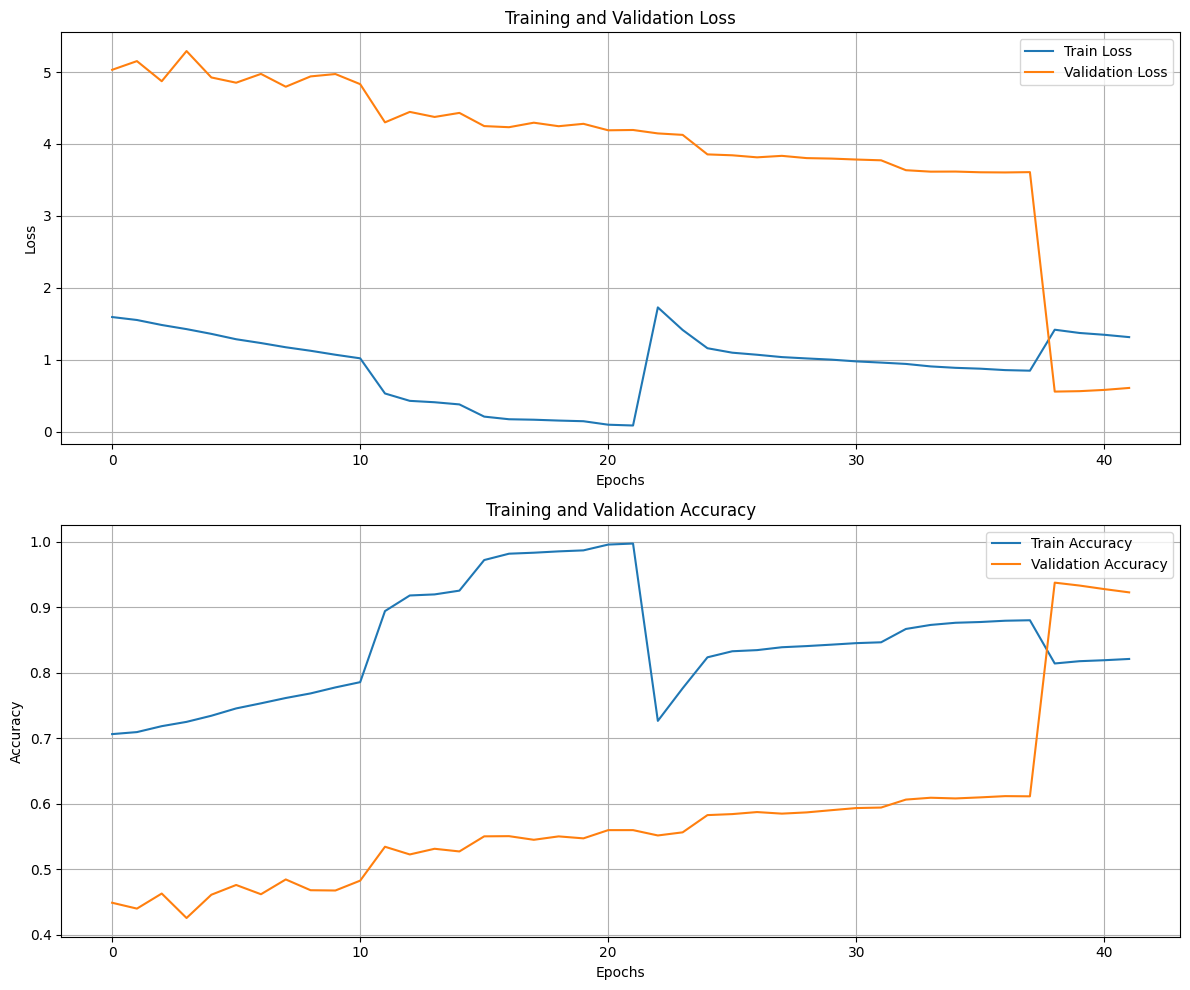

In [ ]:
# Plot training history
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['dev_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['dev_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
model.eval()
predictions = []
true_labels = []

with torch.no_grad():  # No gradient calculation during inference
    for index in range(len(test_dataset)):
        image, label = test_dataset[index]

        image = image.unsqueeze(0).to(device)  # Add batch dimension
        label = label.to(device)

        # Forward pass without labels (just get class logits)
        logits = model(image, label)
        embedding = model(image)

        # Predicted class
        pred_class = torch.argmax(logits, dim=1).item()

        predictions.append(pred_class)
        true_labels.append(label.item())

# Convert to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Metrics
print("Accuracy:", accuracy_score(true_labels, predictions))
print("Precision:", precision_score(true_labels, predictions, average='weighted'))
print("Recall:", recall_score(true_labels, predictions, average='weighted'))
print("F1 Score:", f1_score(true_labels, predictions, average='weighted'))
print("\nClassification Report:\n", classification_report(true_labels, predictions))

Accuracy: 0.9199157007376185
Precision: 0.9233619046120101
Recall: 0.9199157007376185
F1 Score: 0.9194158098940737

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.82      0.93      0.88        15
           2       0.91      1.00      0.95        10
           3       0.89      0.94      0.92        18
           4       0.89      0.73      0.80        11
           5       0.96      0.96      0.96        23
           6       0.92      0.92      0.92        12
           7       0.80      0.92      0.86        13
           8       1.00      0.67      0.80         6
           9       0.64      1.00      0.78         7
          10       0.89      0.94      0.92        18
          11       1.00      0.89      0.94        18
          12       1.00      0.93      0.97        15
          13       0.93      1.00      0.97        14
          14       0.85      0.92      0.88      

In [ ]:
def generate_person_embedding(model, image):
    # Convert to tensor if numpy array
    if isinstance(image, np.ndarray):
        image = torch.from_numpy(image).float()

    # Convert to float32 if needed
    if image.dtype != torch.float32:
        image = image.float()

    # Normalize to [0,1] if needed
    if image.max() > 1.0:
        image = image / 255.0

    # Ensure proper shape [C, H, W] if input is [H, W, C]
    if image.ndim == 3 and image.shape[-1] == 3:  # HWC format
        image = image.permute(2, 0, 1)  # Convert to CHW

    # Add batch dimension if needed
    if image.ndim == 3:
        image = image.unsqueeze(0)

    # Move to same device as model
    image = image.to(next(model.parameters()).device)

    # Generate embedding
    model.eval()
    with torch.no_grad():
        embedding = model(image)

    return embedding.squeeze().cpu()

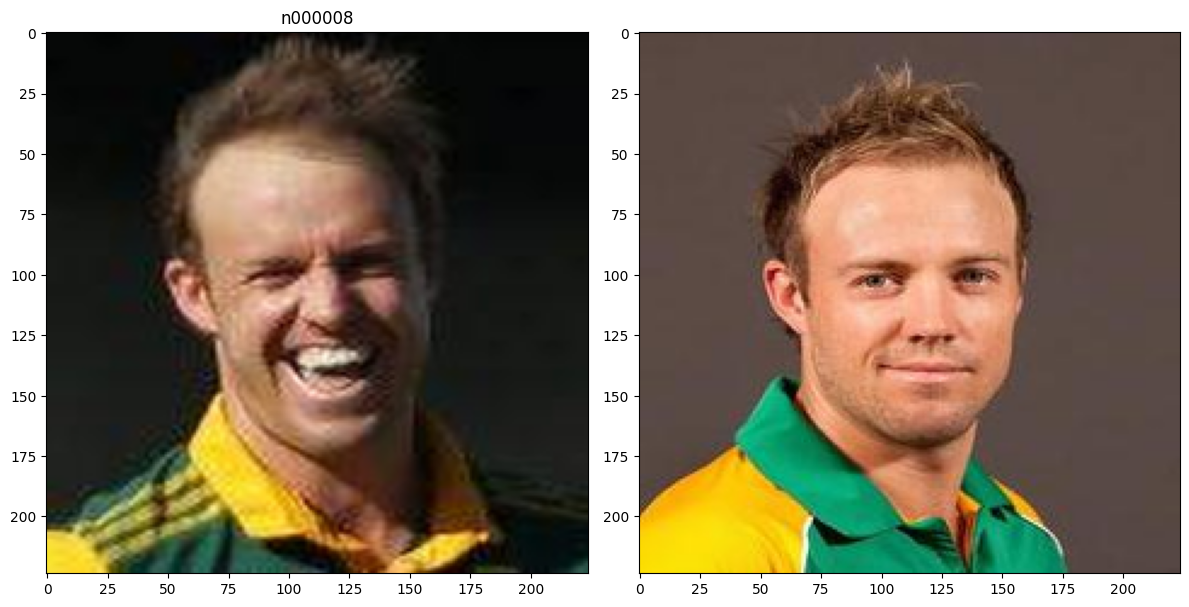

In [ ]:
same_person_test = train_df[train_df['label'] == 'n000008'].sample(2)
different_person_test = train_df[train_df['label'] != 'n000109'].sample(2)

image1 = resize_image(cv2.imread(same_person_test.iloc[0,0]))
image2 = resize_image(cv2.imread(same_person_test.iloc[1,0]))
img_rgb1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
img_rgb2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Plot training history
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb1)
plt.title(f"{same_person_test.iloc[0,1]}")
plt.subplot(1, 2, 2)
plt.imshow(img_rgb2)
plt.tight_layout()
plt.show()

In [ ]:
img1 = generate_person_embedding(model, img_rgb1)
img2 = generate_person_embedding(model, img_rgb2)
emb1 = img1.view(img1.size(0), -1)
emb2 = img2.view(img2.size(0), -1)

In [ ]:
def is_same_person(img1, img2, threshold=0.5):
    similarity = F.cosine_similarity(emb1, emb2)
    avg_sim = similarity.mean().item()
    return avg_sim, avg_sim >= threshold

In [ ]:
is_same_person(img1, img2)

(0.5546875, True)

In [ ]:
cos_sim = F.cosine_similarity(emb1, emb2)
print(cos_sim.shape)  # torch.Size([128])

# Get average similarity
avg_sim = cos_sim.mean().item()
print("Average similarity:", avg_sim)

torch.Size([512])
Average similarity: 0.5546875


In [ ]:
def average_euclidean_distance(x1, x2):
    distances = torch.norm(x1 - x2, dim=1, p=2)
    return distances.mean()

In [ ]:
avg_distance = average_euclidean_distance(emb1, emb2)
print(f"Average Euclidean distfdance: {avg_distance.item():.4f}")

Average Euclidean distfdance: 0.4221


In [ ]:
identities = val_df['label'].drop_duplicates().sample(5, random_state=42)
sampled_df = val_df[val_df['label'].isin(identities)].sample(100, random_state=42)

In [ ]:
labels = []
embeddings = []

In [ ]:
for identity in identities:
    df_identity = sampled_df[sampled_df['label'] == identity].sample(4, random_state=42, replace=True)
    for img_path, label, _ in df_identity.values:
      embedding = generate_person_embedding(model, resize_image(cv2.imread(img_path)))
      labels.append(label)
      embeddings.append(embedding)

In [ ]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.patches as mpatches

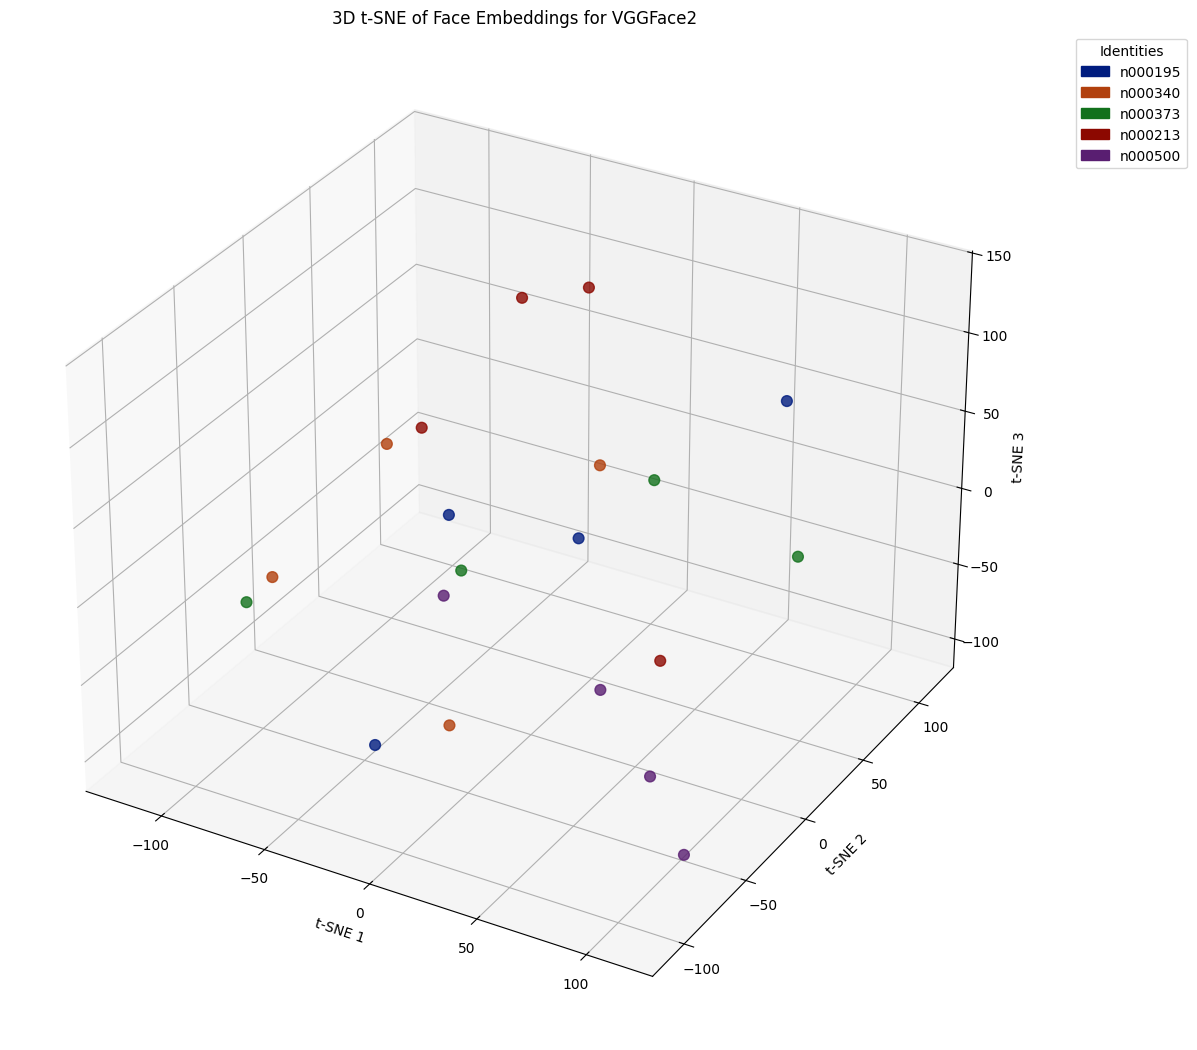

In [ ]:
tsne = TSNE(n_components=3, perplexity=14, random_state=42, max_iter=1000)
embeddings_3d = tsne.fit_transform(np.array(embeddings))

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

unique_labels = list(set(labels))
palette = sns.color_palette("dark", len(unique_labels))
color_map = {label: palette[i] for i, label in enumerate(unique_labels)}
colors = [color_map[label] for label in labels]

# Scatter plot
xs, ys, zs = embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2]
scatter = ax.scatter(xs, ys, zs, c=colors, s=60, alpha=0.8)

# Legend
legend_patches = [mpatches.Patch(color=color_map[label], label=label)
                 for label in unique_labels]
ax.legend(handles=legend_patches, title="Identities", bbox_to_anchor=(1.05, 1), loc='upper left')

# Labels and title
ax.set_xlabel('t-SNE 1'), ax.set_ylabel('t-SNE 2'), ax.set_zlabel('t-SNE 3')
ax.set_title("3D t-SNE of Face Embeddings for VGGFace2")

plt.tight_layout()
plt.show()